In [47]:
!pip install obspy

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
from obspy.signal.trigger import classic_sta_lta
import glob
from obspy import read
from datetime import datetime, timedelta


In [50]:
# Part 2: Load Training Data
# Load the CSV file into a DataFrame
lunar = pd.read_csv(f"/content/drive/MyDrive/space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv")

print("Column names in the DataFrame:")
print(lunar.columns)

# Fix column names for 'time_abs'
lunar.rename(columns={'time_abs(%Y-%m-%dT%H:%M:%S.%f)': 'time_abs'}, inplace=True)

# Convert 'time_abs' to pandas datetime format
lunar['time_abs'] = pd.to_datetime(lunar['time_abs'])

# Display the first few rows to check the data
lunar.head()


Column names in the DataFrame:
Index(['filename', 'time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'evid',
       'mq_type'],
      dtype='object')


,filename,time_abs,time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19 20:25:00,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25 03:32:00,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26 20:17:00,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25 01:14:00,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26 14:29:00,52140.0,evid00007,deep_mq


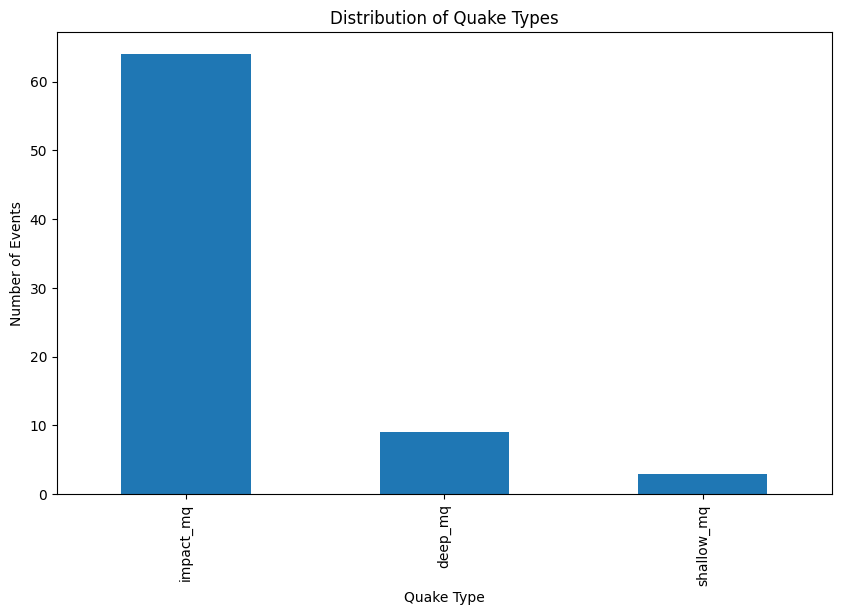

((60, 7), (16, 7), (60,), (16,))

In [51]:
# Part 3: Data Exploration and Feature Engineering
# Plot the distribution of quake types
lunar['mq_type'].value_counts().plot(kind='bar', title="Distribution of Quake Types", figsize=(10, 6))
plt.xlabel("Quake Type")
plt.ylabel("Number of Events")
plt.show()

# Feature Engineering: Extract hour, day, month, etc., from Abs_Time
lunar['Hour'] = lunar['time_abs'].dt.hour
lunar['Day'] = lunar['time_abs'].dt.day
lunar['Month'] = lunar['time_abs'].dt.month
lunar['Year'] = lunar['time_abs'].dt.year

# Encode the 'filename' and 'mq_type' as numeric using LabelEncoder
file_name_encoder = LabelEncoder()
lunar['File_Name_Encoded'] = file_name_encoder.fit_transform(lunar['filename'])

quake_type_encoder = LabelEncoder()
lunar['MQ_Type_Encoded'] = quake_type_encoder.fit_transform(lunar['mq_type'])

# Drop unused columns for classification
features = lunar.drop(columns=['time_abs', 'filename', 'mq_type', 'evid'])
target = lunar['MQ_Type_Encoded']

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Check the shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

Random Forest
Accuracy = 0.94%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.93      1.00      0.97        14
           2       0.00      0.00      0.00         1

    accuracy                           0.94        16
   macro avg       0.64      0.67      0.66        16
weighted avg       0.88      0.94      0.91        16

Confusion Matrix
[[ 1  0  0]
 [ 0 14  0]
 [ 0  1  0]]
Logistic Regression
Accuracy = 0.88%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.88      1.00      0.93        14
           2       0.00      0.00      0.00         1

    accuracy                           0.88        16
   macro avg       0.29      0.33      0.31        16
weighted avg       0.77      0.88      0.82        16

Confusion Matrix
[[ 0  1  0]
 [ 0 14  0]
 [ 0  1  0]]


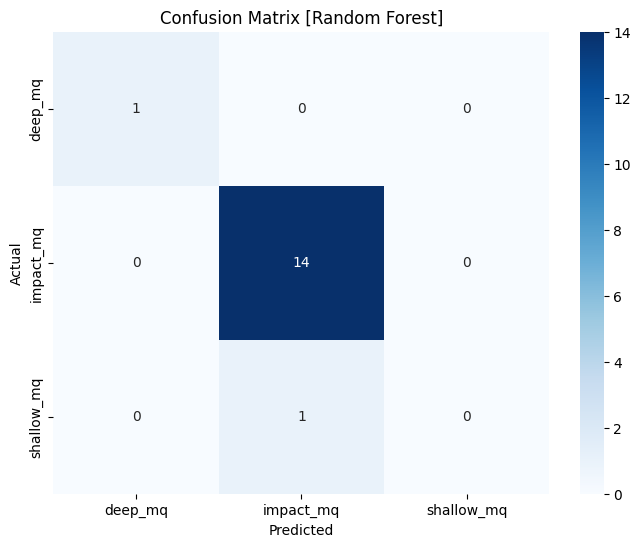

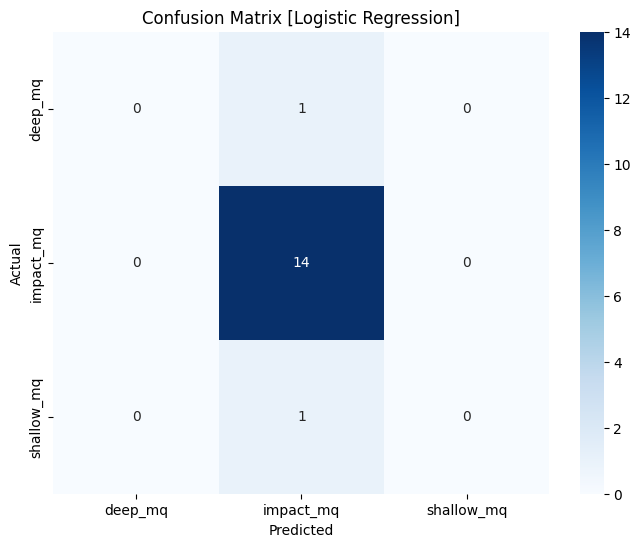

In [52]:
# Part 4: Model Training and Evaluation
# Create models
rf_model = RandomForestClassifier(random_state=42)
logreg = LogisticRegression(random_state=42)

# Train the models
rf_model.fit(X_train, y_train)
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)
y_pred_lr = logreg.predict(X_test)

# Evaluate Random Forest model
print("Random Forest")
print(f"Accuracy = {accuracy_score(y_test, y_pred_rf):.2f}%")
print(f"Classification Report:\n{classification_report(y_test, y_pred_rf)}")
print(f"Confusion Matrix\n{confusion_matrix(y_test, y_pred_rf)}")

print("="*50)

# Evaluate Logistic Regression model
print("Logistic Regression")
print(f"Accuracy = {accuracy_score(y_test, y_pred_lr):.2f}%")
print(f"Classification Report:\n{classification_report(y_test, y_pred_lr)}")
print(f"Confusion Matrix\n{confusion_matrix(y_test, y_pred_lr)}")

# Visualize confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=quake_type_encoder.classes_, yticklabels=quake_type_encoder.classes_)
plt.title('Confusion Matrix [Random Forest]')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize confusion matrix for Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=quake_type_encoder.classes_, yticklabels=quake_type_encoder.classes_)
plt.title('Confusion Matrix [Logistic Regression]')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [53]:
# Function to load and concatenate all CSV files from the test folder
def load_test_data(test_folder):
    test_data = pd.DataFrame()
    for root, dirs, files in os.walk(test_folder):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                temp_df = pd.read_csv(file_path)
                test_data = pd.concat([test_data, temp_df], ignore_index=True)
    return test_data

# Load the test dataset
test_folder = "/content/drive/MyDrive/space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/lunar/test/data/S15_GradeA"
test_data = load_test_data(test_folder)

# Display the first few rows to check the test data
print("Loaded test data:")
print(test_data.head())

# Rename and convert 'time_abs' to pandas datetime format
if 'time_abs(%Y-%m-%dT%H:%M:%S.%f)' in test_data.columns:
    test_data.rename(columns={'time_abs(%Y-%m-%dT%H:%M:%S.%f)': 'time_abs'}, inplace=True)

test_data['time_abs'] = pd.to_datetime(test_data['time_abs'], errors='coerce')

# Feature engineering: Extract time components (hour, day, month, year)
test_data['Hour'] = test_data['time_abs'].dt.hour
test_data['Day'] = test_data['time_abs'].dt.day
test_data['Month'] = test_data['time_abs'].dt.month
test_data['Year'] = test_data['time_abs'].dt.year

# Ensure 'velocity(m/s)' is converted to float
if 'velocity(m/s)' in test_data.columns:
    test_data['velocity(m/s)'] = test_data['velocity(m/s)'].astype(float)

# Drop 'time_abs' as it is no longer needed
test_features = test_data.drop(columns=['time_abs'], errors='ignore')  # Avoid error if column is missing

# Display the first few rows of test_features to check the processed data
print("Processed test features:")
print(test_features.head())


Loaded test data:
  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0     1973-04-04T00:59:42.936191       0.000000   1.400655e-14
1     1973-04-04T00:59:43.087134       0.150943   2.051860e-14
2     1973-04-04T00:59:43.238078       0.301887   2.350687e-14
3     1973-04-04T00:59:43.389021       0.452830   2.212263e-14
4     1973-04-04T00:59:43.539965       0.603774   1.785002e-14
Processed test features:
   time_rel(sec)  velocity(m/s)  Hour  Day  Month  Year
0       0.000000   1.400655e-14     0    4      4  1973
1       0.150943   2.051860e-14     0    4      4  1973
2       0.301887   2.350687e-14     0    4      4  1973
3       0.452830   2.212263e-14     0    4      4  1973
4       0.603774   1.785002e-14     0    4      4  1973


Index(['Abs_Time', 'Rel_Time', 'STA', 'LTA', 'STA/LTA Ratio'], dtype='object')
Detected events saved to detected_events_sta_lta.csv


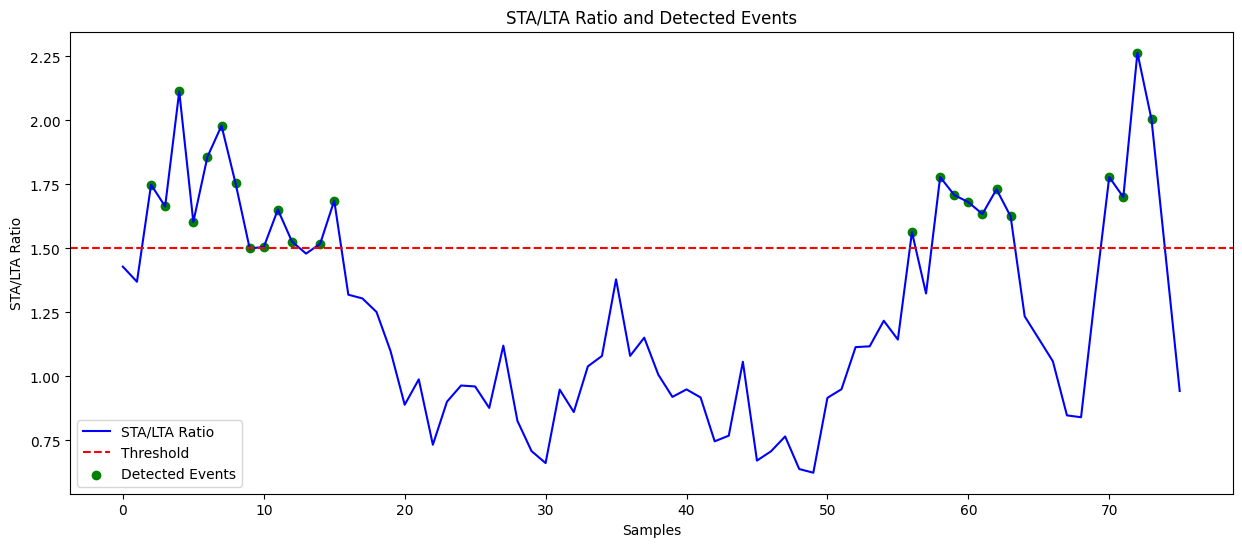

In [54]:
# Extract the seismic signal
signal = lunar['time_rel(sec)'].values

# Define the STA/LTA function
def sta_lta(signal, sta_len, lta_len):
    sta = np.convolve(signal, np.ones(sta_len) / sta_len, mode='same')
    lta = np.convolve(signal, np.ones(lta_len) / lta_len, mode='same')

    min_len = min(len(sta), len(lta))
    sta = sta[:min_len]
    lta = lta[:min_len]

    lta[lta == 0] = np.nan  # Avoid division by zero
    sta_lta_ratio = np.nan_to_num(sta / lta, nan=0.0, posinf=0.0, neginf=0.0)

    return sta, lta, sta_lta_ratio

# Define STA, LTA, and threshold values
sta_length = 5
lta_length = 50
threshold = 1.5

# Calculate STA, LTA, and STA/LTA ratio
sta, lta, sta_lta_ratio = sta_lta(signal, sta_length, lta_length)

# Detect events based on the threshold
detected_events = sta_lta_ratio > threshold

# Extract event details for detected events (without 'filename')
event_times = lunar['time_abs'][detected_events]
event_times_rel = lunar['time_rel(sec)'][detected_events]

# Create DataFrame for detected events
df_events = pd.DataFrame({
    "Abs_Time": event_times,
    "Rel_Time": event_times_rel,
    "STA": sta[detected_events],
    "LTA": lta[detected_events],
    "STA/LTA Ratio": sta_lta_ratio[detected_events]
})
print(df_events.columns)

# Save detected events to a CSV
df_events.to_csv('detected_events_sta_lta.csv', index=False)
print(f"Detected events saved to detected_events_sta_lta.csv")

# Visualize the STA/LTA results
plt.figure(figsize=(15, 6))
plt.plot(sta_lta_ratio, label='STA/LTA Ratio', color='blue')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(np.arange(len(sta_lta_ratio))[detected_events], sta_lta_ratio[detected_events], color='green', label='Detected Events')
plt.title('STA/LTA Ratio and Detected Events')
plt.xlabel('Samples')
plt.ylabel('STA/LTA Ratio')
plt.legend()
plt.show()


In [55]:
output_catalog = pd.DataFrame({
    "filename": lunar['filename'][:len(detected_events)][detected_events],
    "time_abs(%Y-%m-%dT%H:%M:%S.%f)": lunar['time_abs'][:len(detected_events)][detected_events],  # Adjust this to the correct column name
    "time_rel(sec)": lunar['time_rel(sec)'][:len(detected_events)][detected_events]  # Include time_rel if needed
})


# Specify the output file path
output_file_path = 'detected_events_catalog_test.csv'

# Save the catalog to a CSV file
output_catalog.to_csv(output_file_path, index=False)
print(f"Catalog of detected events saved to {output_file_path}")


Catalog of detected events saved to detected_events_catalog_test.csv


### Alternatively: read the miniseed file corresponding to that detection

Same procedure as above, just using the miniseed file.

In [56]:
# Define the directory where your MiniSEED files are stored
data_directory = '/content/drive/MyDrive/space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'

# Iterate over each detected event in the DataFrame
for index, row in df_events.iterrows():
    # Access the filename from the 'filename' column in the lunar DataFrame
    if index < len(lunar):  # Ensure index is within bounds
        filename = lunar['filename'].iloc[index]  # Adjust based on index or condition

        # Construct the MiniSEED file path
        mseed_file = f'{data_directory}{filename}.mseed'  # Construct the path

        # Check if the file exists
        if os.path.exists(mseed_file):
            try:
                # Read the MiniSEED file
                st = read(mseed_file)
                print(f"Successfully read: {mseed_file}")
            except Exception as e:
                print(f"Error reading {mseed_file}: {e}")
        else:
            print(f"File does not exist: {mseed_file}")
    else:
        print(f"Index {index} out of bounds for lunar DataFrame.")


Successfully read: /content/drive/MyDrive/space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-03-26HR00_evid00004.mseed
Successfully read: /content/drive/MyDrive/space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-04-25HR00_evid00006.mseed
Successfully read: /content/drive/MyDrive/space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-04-26HR00_evid00007.mseed
Successfully read: /content/drive/MyDrive/space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-06-15HR00_evid00008.mseed
Successfully read: /content/drive/MyDrive/space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-06-26HR00_evid00009.mseed
Successfully read: /content/drive/MyDrive/spa

In [57]:
# The stream file also contains some useful header information
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1975-05-04T00:00:00.457000Z
         endtime: 1975-05-05T00:00:03.023038Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572418
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [58]:
# Assuming the correct column name is 'time_abs'
arrival_time_str = lunar['time_abs'].iloc[index]  # Adjust the column name here if necessary
arrival_time = pd.to_datetime(arrival_time_str, format='%Y-%m-%dT%H:%M:%S.%f')

# Continue with the previous logic for arrival time calculation
tr = st.traces[0].copy()
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()

print(f"Arrival time relative to trace start: {arrival} seconds")

Arrival time relative to trace start: 36299.543 seconds


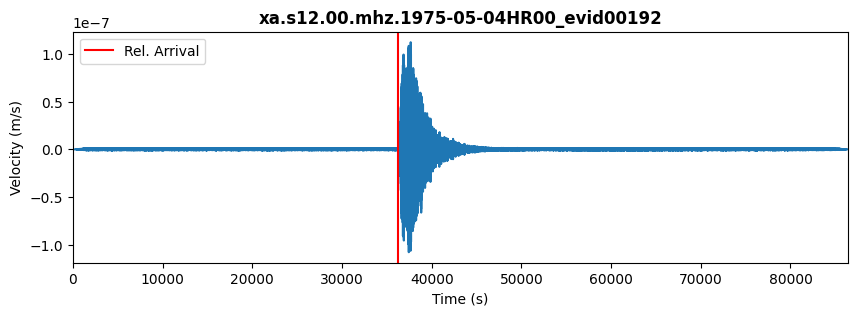

In [59]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# Plot trace
ax.plot(tr_times, tr_data)

# Mark detection
ax.axvline(x=arrival, color='red', label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times), max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

# Use the filename variable you defined earlier (from the DataFrame)
ax.set_title(f'{filename}', fontweight='bold')

plt.show()


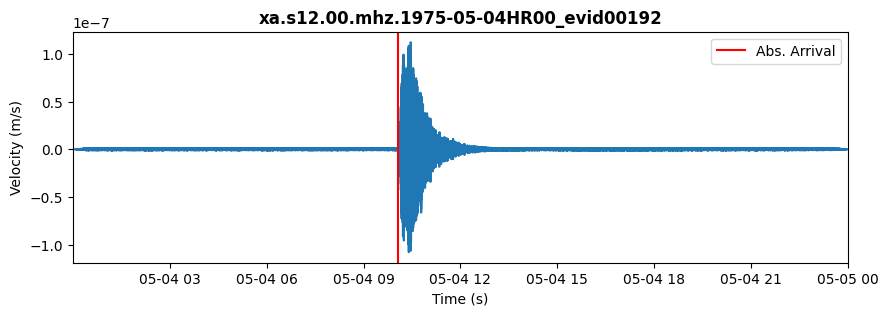

In [60]:
from datetime import timedelta  # Add this import statement

# Create a vector for the absolute time
tr_times_dt = []
for tr_val in tr_times:
    tr_times_dt.append(starttime + timedelta(seconds=tr_val))

# Plot the absolute result
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# Plot trace
ax.plot(tr_times_dt, tr_data)

# Mark detection
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

# Make the plot pretty
ax.set_xlim([min(tr_times_dt), max(tr_times_dt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

# Ensure you use 'filename' instead of 'test_filename'
ax.set_title(f'{filename}', fontweight='bold')

plt.show()


In [61]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [62]:
# To better see the patterns, we will create a spectrogram using the scipy function
# It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

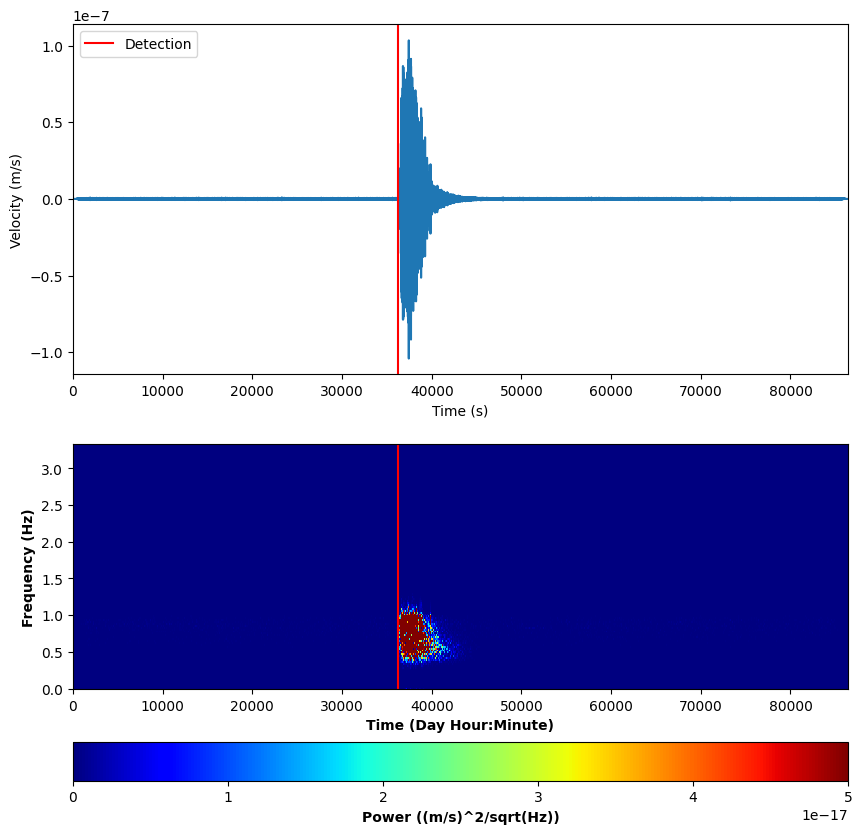

In [63]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

Text(0, 0.5, 'Characteristic function')

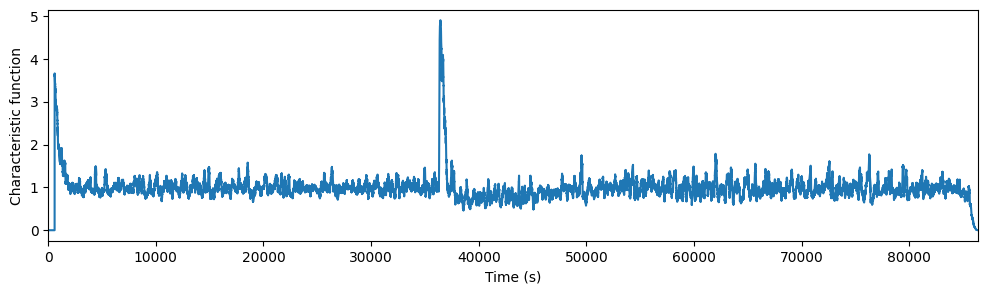

In [64]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 120
lta_len = 600

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

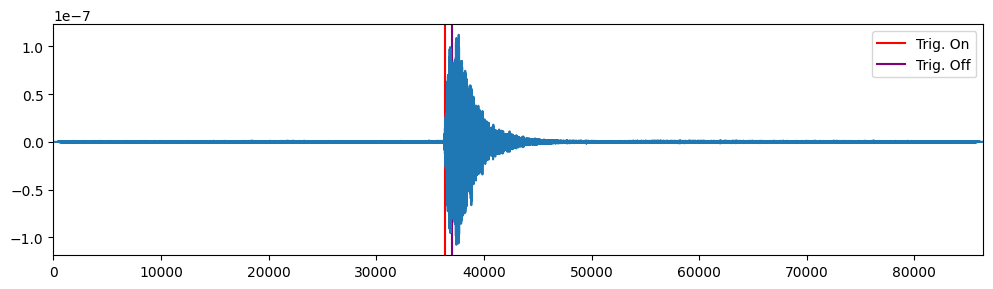

In [65]:
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on".
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()

In [66]:
# Initialize lists for detection times and filenames
detection_times = []
fnames = []
time_rel_sec = []  # Initialize this list here

# Assuming lunar contains 'filename'
for index, row in lunar.iterrows():  # Iterate through each row in lunar
    fname = row['filename']  # Get the filename from the current row

    # Start time of trace; make sure 'tr' is defined and corresponds to the current event
    starttime = tr.stats.starttime.datetime

    # Assuming 'on_off' is defined; iterate through detection times
    for i in range(len(on_off)):
        triggers = on_off[i]

        # Calculate the on_time based on the triggers
        on_time = starttime + timedelta(seconds=tr_times[triggers[0]])
        on_time_str = on_time.strftime('%Y-%m-%dT%H:%M:%S.%f')  # Format the time
        detection_times.append(on_time_str)
        fnames.append(fname)

        # Append the corresponding time_rel_sec value
        time_rel_sec.append(tr_times[triggers[0]])  # Assuming this is the correct way to obtain relative time

# Print lengths for debugging
print(f"Length of fnames: {len(fnames)}")
print(f"Length of detection_times: {len(detection_times)}")
print(f"Length of time_rel_sec: {len(time_rel_sec)}")

# Check if lengths are equal
if len(fnames) == len(detection_times) == len(time_rel_sec):
    # Create a DataFrame for detected events
    detect_df = pd.DataFrame(data={
        'filename': fnames,
        'time_abs(%Y-%m-%dT%H:%M:%S.%f)': detection_times,
        'time_rel(sec)': time_rel_sec
    })

    # Specify the output file path
    output_detect_file_path = 'detected_events_summary.csv'

    # Save the detection summary to a CSV file
    detect_df.to_csv(output_detect_file_path, index=False)
    print(f"Summary of detected events saved to {output_detect_file_path}")
else:
    print("Error: Lists have different lengths. Cannot create DataFrame.")


Length of fnames: 76
Length of detection_times: 76
Length of time_rel_sec: 76
Summary of detected events saved to detected_events_summary.csv


In [67]:
# File name and start time of trace
fname = row.filename
starttime = tr.stats.starttime.datetime
# Iterate through detection times and compile them
detection_times = []
fnames = []
for i in np.arange(0,len(on_off)):
  triggers = on_off[i]
  on_time = starttime + timedelta(seconds = tr_times[triggers[0]])
  on_time_str = datetime.strftime(on_time,'%Y-%m-%dT%H:%M:%S.%f')
  detection_times.append(on_time_str)
  fnames.append(fname)
# Compile dataframe of detections
detect_df = pd.DataFrame(data = {'filename':fnames, 'time_abs(%Y-%m-%dT%H:%M:%S.%f)':detection_times, 'time_rel(sec)':tr_times[triggers[0]]})
detect_df.head()

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec)
0,xa.s12.00.mhz.1975-06-26HR00_evid00198,1975-05-04T10:05:59.853226,36359.396226


This can then be exported to a csv using:

`detect_df.to_csv('output/path/catalog.csv', index=False)`

# **MARS TEST**

In [68]:
import os
import pandas as pd
from obspy import read


In [69]:
# Define your directories
mars_data_directory = '/content/drive/MyDrive/space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/mars/training/data'
catalog_file_path = '/content/drive/MyDrive/space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv'  # Define the path for the catalog file

# Define STA/LTA parameters
sta_length = 5  # Short-term window length in seconds
lta_length = 250  # Long-term window length in seconds
threshold = 2.0  # Detection threshold


# List all MiniSEED files in the directory
all_mseed_files = [f for f in os.listdir(mars_data_directory) if f.endswith('.mseed')]


In [70]:
# Create an empty list to store catalog data
catalog_data = []

# Process each MiniSEED file
for mseed_file in all_mseed_files:
    full_mseed_path = os.path.join(mars_data_directory, mseed_file)

    # Read the MiniSEED file
    try:
        st = read(full_mseed_path)

        for tr in st:
            # Extract relevant information
            catalog_data.append({
                'filename': mseed_file,
                'time_abs': tr.stats.starttime,
                'sampling_rate': tr.stats.sampling_rate,
                # Add more fields if necessary
            })

    except Exception as e:
        print(f"Error reading {full_mseed_path}: {e}")

# Create a DataFrame from the catalog data
mars_catalog_df = pd.DataFrame(catalog_data)

# Save the catalog to a CSV file
mars_catalog_df.to_csv(catalog_file_path, index=False)

# Display the catalog DataFrame
mars_catalog_df.head()


,filename,time_abs,sampling_rate
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed,2022-02-03T08:00:00.009000Z,20.0
1,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed,2022-01-02T04:00:00.025000Z,20.0


In [71]:
def sta_lta_analysis(trace, sta_length, lta_length, threshold):
    # Compute the STA/LTA ratio
    n_sta = int(sta_length * trace.stats.sampling_rate)
    n_lta = int(lta_length * trace.stats.sampling_rate)

    if len(trace.data) < n_lta:  # Ensure enough data for LTA
        return np.array([]), np.array([])  # No detections possible

    sta = np.convolve(trace.data, np.ones(n_sta)/n_sta, mode='valid')
    lta = np.convolve(trace.data, np.ones(n_lta)/n_lta, mode='valid')

    # Ensure both arrays are the same length for division
    min_length = min(len(sta), len(lta))
    ratio = sta[:min_length] / lta[:min_length]

    detections = np.where(ratio > threshold)[0]

    return detections, ratio


In [72]:
# Process existing .mseed files for STA/LTA analysis and plotting
results = []  # Reset results

for mseed_file in all_mseed_files:
    full_mseed_path = os.path.join(mars_data_directory, mseed_file)

    try:
        st = read(full_mseed_path)
        print(f"Successfully read: {full_mseed_path}")

        # Process each trace in the stream
        for tr in st:
            detections, ratio = sta_lta_analysis(tr, sta_length, lta_length, threshold)

            # Store results and plot if detections were found
            if len(detections) > 0:
                results.append({
                    'filename': mseed_file,
                    'detections': detections,
                    'ratio': ratio,
                    'start_time': tr.stats.starttime,
                    'end_time': tr.stats.endtime,
                    'sampling_rate': tr.stats.sampling_rate
                })
                # Call your plotting function here if needed
                # plot_stalta_results(tr, detections, ratio, mseed_file)
            else:
                print(f"No detections found in {mseed_file}")

    except Exception as e:
        print(f"Error reading {full_mseed_path}: {e}")

# Convert results to a DataFrame for further analysis
results_df = pd.DataFrame(results)


# Display the results DataFrame
print("Results DataFrame:", results_df)


Successfully read: /content/drive/MyDrive/space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed
Successfully read: /content/drive/MyDrive/space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed
Results DataFrame:                                         filename  \
0  XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed   
1  XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed   

                                          detections  \
0  [183, 184, 185, 186, 187, 188, 189, 190, 191, ...   
1  [581, 582, 583, 584, 585, 586, 587, 588, 589, ...   

                                               ratio  \
0  [0.15577092912663865, 0.12373644807834441, 0.0...   
1  [0.03471870408230727, 0.035592012601048585, 0....   

                    start_time                     end_time  sampling_rate  
0  2022-02-03T08:00:00.009000Z  2022-02-03T08:59:

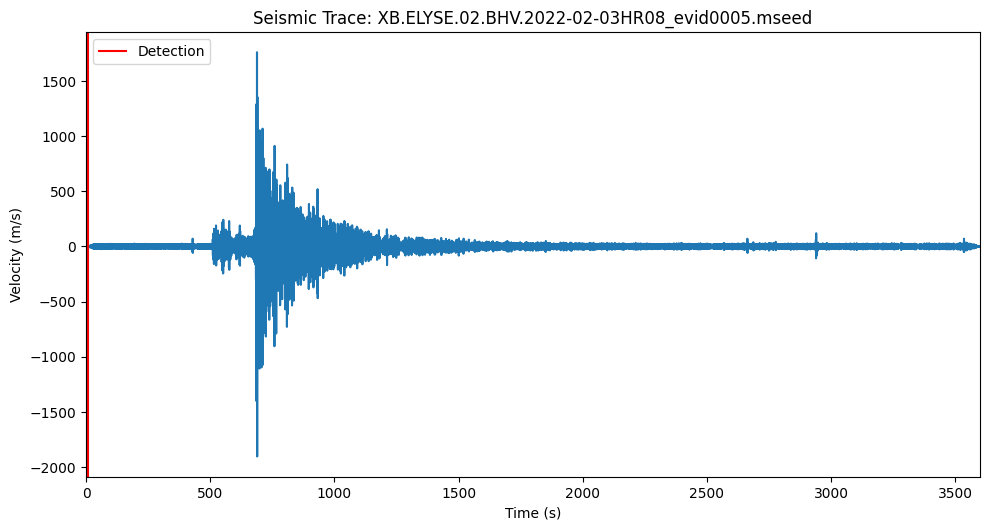

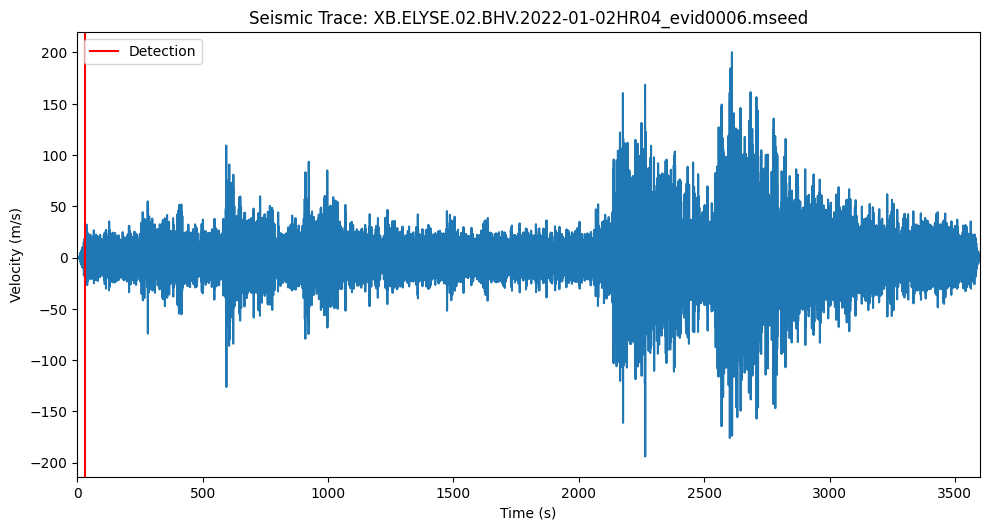

In [73]:
import pandas as pd
import os

# Function to plot seismic trace and STA/LTA results
def plot_stalta_results(tr, detections, filename):
    # Set the minimum frequency
    minfreq = 0.5
    maxfreq = 1.0

    # Create a filtered trace for the plot
    st_filt = tr.copy()
    st_filt.filter('bandpass', freqmin=minfreq, freqmax=maxfreq)
    tr_filt = st_filt.copy()

    # Create the plot
    fig = plt.figure(figsize=(10, 10))
    tr_times_filt = tr_filt.times()

    # Plot the trace
    ax = plt.subplot(2, 1, 1)
    ax.plot(tr_times_filt, tr_filt.data)
    if len(detections) > 0:
        ax.axvline(x=tr_times_filt[detections[0]], color='red', label='Detection')  # mark first detection
    ax.legend(loc='upper left')
    ax.set_xlim([min(tr_times_filt), max(tr_times_filt)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'Seismic Trace: {filename}')

    plt.tight_layout()
    plt.show()

# Plot results for each detection
for index, row in results_df.iterrows():
    full_mseed_path = os.path.join(mars_data_directory, row['filename'])

    # Read the trace again for plotting
    st = read(full_mseed_path)
    for tr in st:
        plot_stalta_results(tr, row['detections'], row['filename'])


In [74]:
# Create the final catalog DataFrame
catalog_data = []

for index, row in results_df.iterrows():
    time_abs = row['start_time'].isoformat()  # or convert to desired format
    catalog_data.append({
        'filename': row['filename'],
        'time_abs': time_abs,
        'sampling_rate': row['sampling_rate']
    })

# Convert to DataFrame
catalog_df = pd.DataFrame(catalog_data)

# Save to CSV
catalog_file_path = os.path.join(mars_data_directory, 'catalog.csv')
catalog_df.to_csv(catalog_file_path, index=False)
print(f"Catalog saved to: {catalog_file_path}")


Catalog saved to: /content/drive/MyDrive/space_apps_2024_seismic_detection/space_apps_2024_seismic_detection/data/mars/training/data/catalog.csv


## Thank you very much for being a part of this challenge! Good luck!!!

You may find that you need to download additional data from Earth stations to supplement your models and algorithms. We recommend that you download any events from IRIS (Incorporated Research Institutations for Seismology).

https://www.iris.edu/hq/

**Note**: The organization has been recently renamed to SAGE (Seismological Facility for the Advancement of Geoscience), but all the previous links should still work.

They maintain and curate data from seismic stations all around the world. There are many different ways to get data from them, but I recommend using the utility *PyWeed*:

https://ds.iris.edu/ds/nodes/dmc/software/downloads/pyweed/

We can use the utility to select seismic stations and the earthquake data (or **events**) recorded at those stations.

<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/eq_detector_images/station_data_location.png" alt="Drawing" style="width: 1200px;">

For this test case, let's download all of the earthquakes magnitude 3 and above that are within 1 degree distance (approximately 110 km) from a site called PFO (Pinon Flat Observatory) in California. **Location** is a number designating the instrument at a particular site (sites may have multiple instruments), and **channel** is an IRIS code that specifies instrument information.

In short, the first latter refers to the samplerate of the instrument (how many data points it records per second), the second to the type of instrument (certain types of seismometers are better at recording nearby earthquakes while others are more suited for distant earthquakes), and the last to the directional component being recored (most seismometers will record motion across two horizontal directions and the vertical). We will pick the channel HHZ, which refers to a (H) high-samplerate (100 samples per second) (H) strong-motion accelerometer (best resolution for nearby strong earthquakes) recording in the (Z) vertical direction. Once you've selected all the earthquakes, you can download the traces.

An earthquake is composed of the following types of waves (in order): pressure (P-wave), shear (S-wave), and surface (Rayleigh and Love). For our challenge, we are only interested in identifying the start of the earthquake. The IRIS dataset contains P-wave arrivals (onset of the P-wave at the seismometer) for each earthquake. In order to get noise prior to the earthquake arrival, we pick our data traces to span 101 seconds before to 60 seconds past the P-wave arrival:


<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/eq_detector_images/selected_seismograms.png" alt="Drawing" style="width: 1200px;">


As you can see from the output list, some of the earthquakes don't record any earthquake data (3.4 Ml 2005-08-31) and others have an incorrect P-wave arrival time (4.0 Ml 2005-08-31). Make sure to go through the earthquakes and remove those types of events from the waveform preview prior to download. For output file type, choose miniseed to match the planetary data (SAC is probably fine too, but the file sizes tend to be a bit bigger).